In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Simplest of Possible GPs
#### Interpolation between error free data points
###### sample from GP prior with a linear or sqexponential kernel 
###### encode similarity along dimension x, similar x values will have similar y values

###### some code taken from  Martin Krasser's
###### https://github.com/krasserm/bayesian-machine-learning


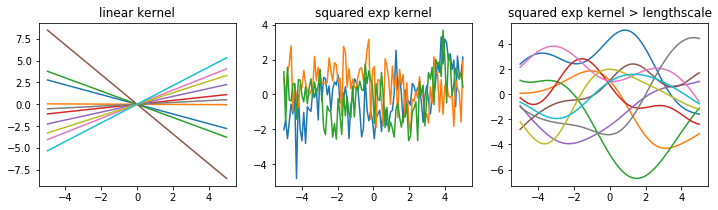

In [52]:
# kernel function gives you the covariance matrix between vectors a and b
n = 100
x = np.linspace(-5,5,n).reshape(-1,1)
y = np.array([1,2,3]).reshape(-1,1)


def kernel(a,b, l=1, sigmaf=1 , sigmay=0,  t_kernel ='sqexp'):
    
    if t_kernel == 'linear':
        return   (a @ b.T)  * 1
    if t_kernel == 'sqexp' and a.shape == b.shape:
        "only works if a and be same sized"
        diff = (a-b.T)**2
        return sigmaf**2 * np.exp((-1/(2*l**2)) * diff)  + sigmay**2 * np.eye(np.size(b))
    else:
        " use two for loops for mxd and nxd matrices.  " 
        " returns mxn covariance matrix " 
        " doesn't allow for error in data "
        K = np.zeros([a.shape[0],b.shape[0]])
        for xi,i in enumerate(a):
            for xj,j in enumerate(b):
                diff = (i-j)**2
                K[xi,xj] = sigmaf**2 * np.exp((-1/(2*l**2)) * diff)
        return K
    
    
    
def GP(x, y, t_kernel='linear', l=1, sigmay=1, sigmaf=1, n_functions=10):
    
    # User defined kernel on user defined dimensions
    # returns nxn covariance matrix
    K = kernel(x,y, t_kernel=t_kernel, sigmay=sigmay, sigmaf=sigmaf,l=l)
    # Use Cholesky decomposition K = LL.T (the square root of a matrix)
    L = np.linalg.cholesky(K + 1e-13*np.eye(n)) # has to be square
    # sample from random normal
    rand = np.random.normal(size=(n,n_functions))
    func = L @ rand
    return func, L, K

f1,L1,K1 = GP(x,x,t_kernel='linear')
f2,L2,K2 = GP(x,x,t_kernel='sqexp', n_functions=3)
f3,L3,K3 = GP(x,x,t_kernel='sqexp',sigmay=1e-4,sigmaf=2,l=2)

fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(12,3))
ax[0].plot(x,f1)
ax[0].set_title('linear kernel')
ax[1].plot(x,f2)
ax[1].set_title('squared exp kernel')
ax[2].plot(x,f3)
ax[2].set_title('squared exp kernel > lengthscale');

Essentially what is happening here is that I am generating a random vector (rand) of size (n,1) from a standard normal distribution N(0,1). I am then matrix multiplying this realization (rand) to the square root of the covariance matrix K. 

$f_{*} \sim \mu + L\mathcal{N}{(0, I)}$

$LL^T = \Sigma_{*}$ 

This imparts some of the information on how similar we think our data should be. Here I am simply using the x axis as the measure of similarity, but this doesn't have to be the case. 

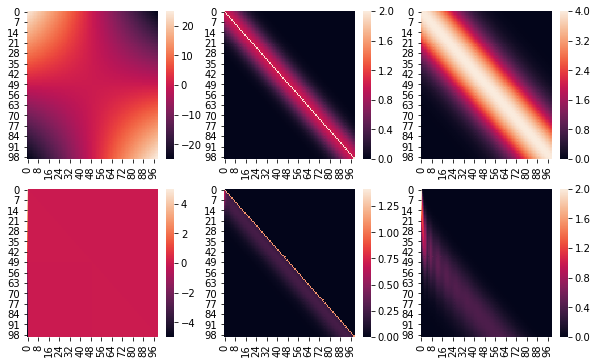

In [19]:
# differnt kernel covariance matrices and their respective square roots L
fig, ax = plt.subplots(2,3, figsize=(10,6))
sns.heatmap(K1, ax=ax[0,0])
sns.heatmap(K2, ax=ax[0,1])
sns.heatmap(K3, ax=ax[0,2])
sns.heatmap(L1, ax=ax[1,0])
sns.heatmap(L2, ax=ax[1,1])
sns.heatmap(L3, ax=ax[1,2]);

###### Now fit GP to some Data

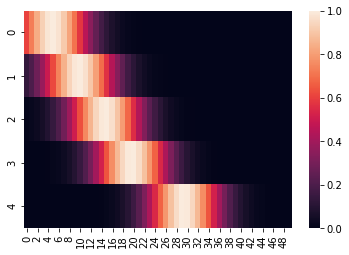

In [25]:
K_s = kernel(Xtrain, Xtest)
sns.heatmap(K_s)

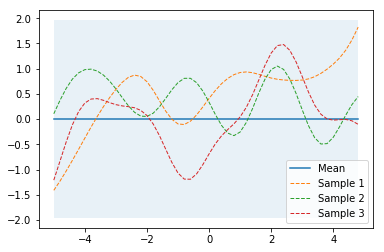

In [124]:
from gaussian_processes_util import plot_gp

import sys, importlib
importlib.reload(sys.modules['gaussian_processes_util'])
from gaussian_processes_util import plot_gp

# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, confidence interval and samples 
plot_gp(mu, cov, X, samples=samples)

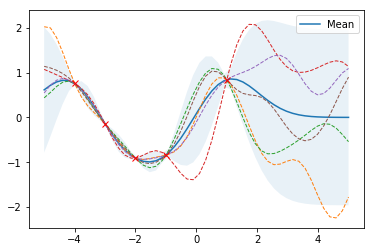

In [134]:
from numpy.linalg import inv

import numpy as np

def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)


def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    '''
    Computes the suffifient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f) 
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (15.15) p.520 murphy
    mu_s = K_s.T @ K_inv @ Y_train
    # Equation (15.16)
    cov_s = K_ss - K_s.T @ K_inv @ K_s
    
    return mu_s, cov_s

# Noiseless training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1,1)
Y_train = np.sin(X_train)
n=50
X_s = np.linspace(-5,5,n).reshape(-1,1)

mu_s, cov_s = posterior_predictive(X_s,Xtrain,ytrain)
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 5)
plot_gp(mu_s, cov_s, X_s, X_train=X_train, Y_train=Y_train, samples=samples, label=False)

In [128]:
mu_s.shape, cov_s.shape


((500, 1), (500, 500))

Basically what we've done here is take a set of *test* points, say 50 along the x axis and asked given the training points and the given covariance/kernel function to test for similarity find a MvN with fifty means one for each *test* point and fifty by fifty covariance structure that keeps similar points similar. The marginal of each of these test points is a one dimensional gaussian and its width its sd. Thats what gives us confidence in the prediction at each x. 

For western wheat I am using lat and long(well distance) as similarity so i will have to change the kernel function. and in the z direction I have w or slope between individual regressions for each farm. 
 

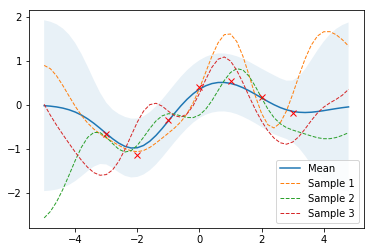

In [131]:
# now with noisey data

noise = 0.4

# Noisy training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, sigma_y=noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

Noise enters the model by adding variance aloing the diagnol in our covariance kernel function. We keep the same relation or metric of similarity between x's, now however, we have added uncertainty in the training covariance and by virtue in the posteior covariance matrix as well. 


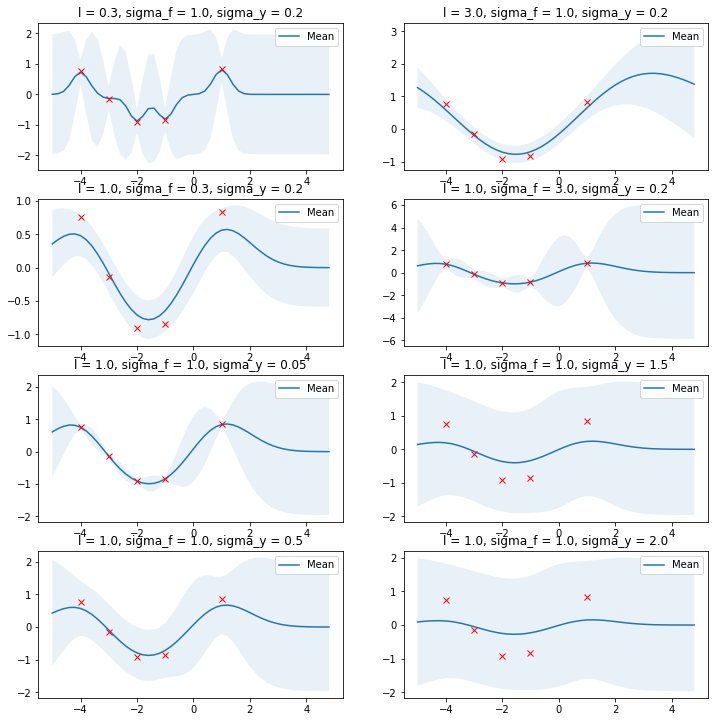

In [138]:
import matplotlib.pyplot as plt

params = [
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
    (1.,1.,.5),
    (1.,1.,2.),

]

plt.figure(figsize=(12, 5))

for i, (l, sigma_f, sigma_y) in enumerate(params):
    mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=l, 
                                       sigma_f=sigma_f, 
                                       sigma_y=sigma_y)
    plt.subplot(4, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}, sigma_y = {sigma_y}')
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

###### Using pymc3 for one d GP

###### with kernel function:
$k(x, x') = \mathrm{exp}\left[ -\frac{(x - x')^2}{2 \ell^2} \right]$

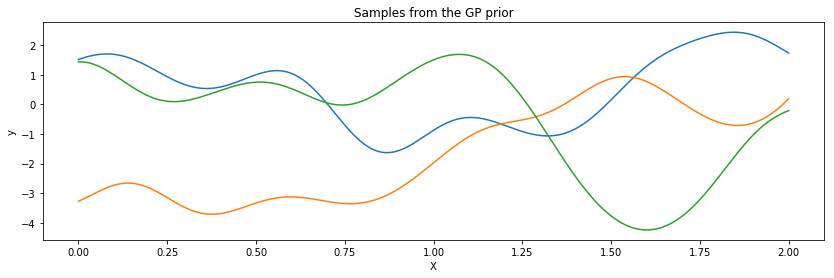

In [143]:
lengthscale = 0.2
eta = 2.0
cov = eta**2 * pm.gp.cov.ExpQuad(1, lengthscale)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.title("Samples from the GP prior");
plt.ylabel("y");
plt.xlabel("X");


###### *latent* implementation

In [146]:
# A one dimensional column vector of inputs.
Xtrain = np.array([-4, -3, -2, -1, 1]).reshape(5,1)
ytrain = np.sin(Xtrain)

with pm.Model() as model:
    # Specify the covariance function.
    cov_func = pm.gp.cov.ExpQuad(1, ls=0.1)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Latent(cov_func=cov_func)

    # Place a GP prior over the function f.
    f = gp.prior("f", X=X)

    trace = pm.sample(1000)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rotated_]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:03<00:00, 1885.37draws/s]


In [ ]:
# After fitting or sampling, specify the distribution
# at new points with .conditional
Xnew = np.linspace(-1, 2, 50)[:, None]

with model:
    fstar = gp.conditional("fcond", Xnew=Xnew)

In [149]:
#pm.traceplot(trace);

<bound method _tensor_py_operators.var of fcond>